In [1]:
%matplotlib inline
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import json
import os
from urllib.request import urlopen
from urllib.error import URLError

# Real would image classification

This scipt classifies real world images using a pretrained neural network called VGG16. We start by downloading all its pretrained parameters, if they have not been downloaded yet, and then load the model.

In [2]:
# check if we can access the pretrained VGG16 weights
try:
    f = open('/it/student/sml/models/vgg16-397923af.pth', 'r')
except OSError:
    pass
else:
    print("using the pretrained VGG16 weights in /it/student/sml/")
    f.close()
    os.environ['TORCH_HOME'] = '/it/student/sml/'

vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/jovyan/.cache/torch/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

We switch the network to evaluation mode (that disables dropout and other features specific for training) and print a summary of the network architecture.

In [3]:
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

The pretrained VGG16 model [expects](https://pytorch.org/docs/master/torchvision/models.html#classification)
>  input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`. 

Thus we define the following set of preprocessing steps, that resizes an input image, crops it to the requested size, converts the pixels to values in [0, 1], and then normalizes them accordingly. 

In [4]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

To be able to analyze the predictions of the model, we load [curated list of human-readable labels](https://github.com/anishathalye/imagenet-simple-labels) for the 1000 classes of the ImageNet dataset with which the model has been trained.

In [5]:
with urlopen('https://git.io/JvBFb') as f:
    LABELS = json.load(f)

We load an image that we want to classify, either from a local folder or the internet.

RGB image of size (4000, 2248)


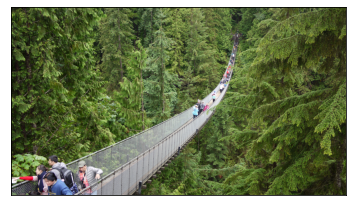

In [21]:
# URL of the image that we want to analyze
# prepend 'file:' to local paths (e.g., use 'file:./gorilla.jpeg')
image_url = 'https://w.wiki/HaQ'

# some examples from Wikipedia:
# Gorilla https://w.wiki/HaK
# Uppsala cathedral https://w.wiki/HaV
# African bush elephant https://w.wiki/HaH
# Pelle Svanslös https://w.wiki/HaG
# Hedgehog https://w.wiki/HaJ
# Suspension bridge https://w.wiki/HaQ

try:
    with Image.open(urlopen(image_url)) as im:
        # The following fixes some problems when loading images:
        # https://stackoverflow.com/a/64598016
        image = im.convert("RGB")
except (URLError, OSError):
    print("please provide a valid URL or local path")
else:    
    print(f"{image.mode} image of size {image.size}")
    plt.imshow(np.asarray(image))
    plt.xticks([])
    plt.yticks([])
    plt.show()

We preprocess the image, retrieve the predicted probabilities from the VGG16 model.

In [22]:
# perform the pre-processing and form a "batch" of one single image
X = preprocess(image).unsqueeze(0)

# obtain the predicted probabilities for the image
with torch.no_grad():
    G = F.softmax(vgg16(X), dim=1)[0]

We plot the image and print the human-readable labels of the top5 predictions.

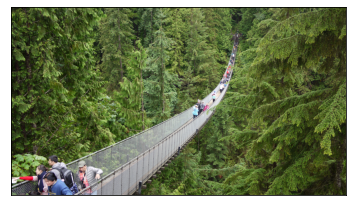

suspension bridge (99.92%)
pole (0.02%)
viaduct (0.01%)
pier (0.01%)
valley (0.01%)


In [23]:
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.show()

for (p, y) in zip(*(G.topk(5))):
    print(f"{LABELS[y.item()]} ({100 * p.item():.2f}%)")